# Rumex detection notebook
The original code is available [here](https://github.com/satnih/rumex) and the data can be downloaded from [here](https://zenodo.org/record/5119205#.ZD3Qt5FBzmF).

João Valente, Santosh Hiremath, Mar Ariza-Sentís, Marty Doldersum, Lammert Kooistra. [*Mapping of Rumex obtusifolius in nature conservation areas using very high resolution UAV imagery and deep learning.*](https://doi.org/10.1016/j.jag.2022.102864) **International Journal of Applied Earth Observations and Geoinformation, 122.** (2022)

## Class description:
- **Label: 0** (Background)
- **Label: 1** (Rumex obtusifolius)

## Channel description:
- **Channel: 1** (Red - R)
- **Channel: 2** (Green - G)
- **Channel: 3** (Blue - B)

## Python requirements:
- pytorch 1.12.0
- torchvision 0.13.0
- captum 0.6.0

In [1]:
import os
import time
import warnings
from time import strftime
from functools import partial

import xmltodict
import xml.etree.ElementTree as et

import matplotlib.pyplot as plt

import numpy as np
from skimage import io as skio
from skimage.util.shape import view_as_blocks
from scipy.special import expit

import torch
from torch.utils.data import DataLoader    
import torch.nn.functional as F

from captum.attr import IntegratedGradients, InputXGradient, DeepLift
from captum.attr import Deconvolution, Occlusion
from captum.attr import FeatureAblation, FeaturePermutation
from captum.attr import GuidedBackprop, GuidedGradCam, LayerGradCam
from captum.attr import DeepLiftShap, GradientShap, KernelShap

from datasets import RumexDataset, BalancedRumexDataset, RumexTestDataset
from models import ResNet18, ResNet101, ConvNeXtTiny, ViT_B_16
from utils import color_codes, time_to_string


The imports can be divided into a few different groups:
- **General packages**: This group include basic python libraries (included with any distribution of python) to perform basic operations relations to files, measuring execution time or function utilities.
- **XML packages**: The annotations for this dataset are stored in xml files, so we need a set of tools to interpret them and construct variables for network training and testing.
- **Plotting tools**: matplotlib (and seaborn) is the most commonly useful visualisation tool for plotting results.
- **Scientific tools**: This larger group includes numpy (equivalent to matlab array processing), scipy (numpy extension for scientific projects) and sklearn (and its image analysis extension). These packages provide tools to manipulate data.
- **Autodifferentiable packages**: For this notebook we will be using pytorch as our tool to build and train deep learning models.
- **Attribution tools**: Captum is a powerful package that leverages some of the modern techniques to interpret the results of trained neural networks. These tools provide a set of saliency maps that highlight regions of interest in the image.
- **Tools from the repository**: To simplify our networks, some of the meaty code is stored on a relevant file including dataset implementations, models based on torchvision and other utils.

# Main functions
The following cell contains two main functions that will be used to run all the experiments for the dataset.

```python
def attribution(x, attr_m, *args, **kwargs)
```

This first function is used as a wrapper for the generation a final saliency map based on the output of the relevant Captum method and the input image (**x**). Depending on the attribution method, the map might be unbounded or have a different size than the original image. To fix that and provide a storable image, this function makes the necessary transformations.

Since the function acts as a wrapper and the attribution method (**attr_m**) might require additional parameters, we need **args** and **kwargs** as input parameters that are then passed to the attribution method as either a list or a dictionary of arguments, respectively.

```python
def run_experiments(
    master_seed, network_name, network, training_files, testing_files, weight_path, maps_path,
    patch_size=256, epochs=10, patience=5, n_seeds=30, n_classes=2, train_batch=20,
    test_batch=50, saliency_batch=4, verbose=1
)
```

This is the main function involved in the experimentation process. To allow for multiple *random* runs, the function requires a **master_seed** (that defines the seed that will used to determine the seeds for each random run). Furthermore a **network_name** is required to display debugging messages regarding the required *function* to instantiate the **network** that will be trained, together with the required lists of **training_files** and **testing_files** with the name of the images containing the mosaic for training and testing, respectively; and the **weight_path** and **maps_path** where the model weights and salienc maps will be stored. The other parameters relate to the network hyperparameters and training / optimisation parameters and are optional.

In [2]:
# warnings.filterwarnings("ignore")

def attribution(x, attr_m, *args, **kwargs):
    """
    Wrapper that contains the attribution method and a set of steps to convert
    the map into a pseudo-heatmap of the same shape as the input image.

    :param x: Original input image.
    :param attr_m: Function for the attribution method
    :param args: Additional arguments in a list format.
    :param kwargs: Additional arguments in a dictionary format.
    :return:
    """
    attr = torch.sigmoid(
        attr_m.attribute(
            x, target=1, *args, **kwargs
        ) / 1e-2
    )
    if x.shape != attr.shape:
        attr = F.interpolate(attr, size=x.size()[2:], mode='bilinear')
    attr_map = attr.squeeze().detach().cpu().numpy()
    return (attr_map * 255).astype(np.uint8)
    
def run_experiments(
    master_seed, network_name, network, training_files, testing_files, weight_path, maps_path,
    patch_size=256, epochs=10, patience=5, n_seeds=30, n_classes=2, train_batch=20,
    test_batch=50, saliency_batch=4, verbose=1
):

    # While we use a BalancedRumexDataset for training, it might
    # be a good idea to also use RumexDataset. The choice of dataset
    # should be coherent with what we do on the other datasets.
    training_set = BalancedRumexDataset(path, training_files, patch_size)
    testing_set = RumexDataset(path, testing_files, patch_size)
    
    # Choosing random runs.
    np.random.seed(master_seed)
    seeds = np.random.randint(0, 100000, n_seeds)
    c = color_codes()
    if verbose > 0:
        print(
            '{:}[{:}] {:}Creating {:}testing{:} dataset '
            'for {:} classification{:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'], c['nc'] + c['y'],
                c['nc'] + c['g'], c['b'] + 'rumex' + c['nc'] + c['g'], c['nc']
            )
        )

    acc_list = []
    class_list = []
    # Main loop to run each independent random experiment.
    for test_n, seed in enumerate(seeds):
        acc = 0
        if verbose > 1:
            print(
                '{:}[{:}] {:}Starting experiment {:}(seed {:05d}){:} [{:02d}/{:02d}] '
                '{:}for {:} classification{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + 'rumex' + c['nc'] + c['g'], c['nc']
                )
            )
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # The network will only be instantiated with the number of output classes
        # (2 in this notebok). Therefore, networks that need extra parameters (like ViT)
        # will need to be passed as a partial function.
        net = network(n_outputs=n_classes)
               
        # This is a leftover from legacy code. If init is set to True (the default option),
        # a first validation epoch will be run to determine the loss before training.
        net.init = False
        
        # The number of parameters is only captured for debugging and printing.
        n_param = sum(
            p.numel() for p in net.parameters() if p.requires_grad
        )
        
        training_loader = DataLoader(
            training_set, train_batch, True
        )
        validation_loader = DataLoader(
            testing_set, test_batch
        )
        model_path = os.path.join(
            weight_path, '{:}-balanced_s{:05d}_p{:03d}.pt'.format(network_name, seed, patch_size)
        )
        
        # For efficiency, we only run the code once. If the weights are
        # stored on disk, we do not need to train again.
        try:
            net.load_model(model_path)
        except IOError:
            net.train()
            net.fit(training_loader, validation_loader, epochs=epochs, patience=patience)
            net.save_model(model_path)
        
        if verbose > 2:
            print(
                '{:}[{:}] {:}Testing {:}(seed {:05d} - {:}){:} [{:02d}/{:02d}] '
                '{:}for {:} classification <{:03d} samples>{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, network_name,
                    c['clr'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + 'rumex' + c['nc'] + c['g'], 
                    len(training_set), c['nc']
                )
            )
        
        # Metric evaluation.
        net.eval()
        with torch.no_grad():
            # Intermediate buffers for class metrics.
            counts = np.zeros(n_classes)
            correct = np.zeros(n_classes)
            for i, (x, y) in enumerate(DataLoader(testing_set, test_batch)):
                pred_y = np.argmax(net.inference(x.numpy()), axis=1).astype(np.uint8)
                y = y.numpy().astype(np.uint8)
                acc += np.sum(y == pred_y) / len(testing_set)
                for k in range(n_classes):
                    k_mask = y == k
                    counts[k] += np.sum(k_mask)
                    correct[k] += np.sum(y[k_mask] == pred_y[k_mask])
            class_acc = [corr_k / num_k for corr_k, num_k in zip(correct, counts)]
            acc_list.append(acc)
            class_list.append(class_acc)
            class_acc_s = ', '.join([
                'Class {:}: {:5.3f}'.format(k, acc_k)
                for k, acc_k in enumerate(class_acc)
            ])
        if verbose > 1:
            print(
                '{:}[{:}] {:}Accuracy {:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'
                '{:5.3f}{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['clr'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'], acc, c['nc']
                )
            )
            print(
                '{:}[{:}] {:}Class accuracies {:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['clr'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'] + class_acc_s + c['nc']
                )
            )
    
    # Metrics for all the runs.
    if verbose > 0:
        print(
                '{:}[{:}] {:}Mean accuracy {:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'
                '{:5.3f}{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['clr'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'], np.mean(acc_list, axis=0), c['nc']
                )
            )
        class_acc_s = ', '.join([
            'Class {:}: {:5.3f}'.format(k, acc_k)
            for k, acc_k in enumerate(np.mean(class_list, axis=0))
        ])
        print(
            '{:}[{:}] {:}Mean class accuracies {:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                c['nc'] + c['y'], seed, c['clr'] + c['c'], test_n + 1, len(seeds),
                c['nc'] + c['b'] + class_acc_s + c['nc']
            )
        )

        print(
            '{:}[{:}] {:}Saliency maps{:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'], c['nc']
            )
        )
    
    # Attribution loop.
    # Due to how these things are coded, we have to run the inference again to
    # obtain the saliency maps.
    net = network(n_outputs=n_classes)
    init_start = time.time()
    for test_n, seed in enumerate(seeds):
        model_path = os.path.join(
            weight_path, '{:}-balanced_s{:05d}_p{:03d}.pt'.format(network_name, seed, patch_size)
        )
        net.load_model(model_path)
        net.eval()
        
        # While this is hard-coded (with choices for optimal waiting time),
        # the method list could be passed as a parameter.
        methods = [
            # 'Input'-based
            # (IntegratedGradients, 'IntegratedGradients', 3, None),
            (InputXGradient, 'InputXGradient', 3, None),
            # Inverse
            (Deconvolution, 'Deconvolution', 3, None),
            # Perturbation-based
            # (Occlusion, 'Occlusion', 3, None),
            # (FeaturePermutation, 'FeaturePermutation', 3, {sliding_window_shapes: (3, 8, 8)}),
            # GradCAM-related
            (partial(LayerGradCam, layer=net.target_layer()), 'LayerGradCam', 1, None),
            (partial(GuidedGradCam, layer=net.target_layer()), 'GuidedGradCam', 3, None),
            (GuidedBackprop, 'GuidedBackprop', 3, None),
        ]
        
        # Not only do we need to run everything again, but we also need
        # to do it file by file (some of these methods require a large
        # amount of RAM).
        # While we could modify the datasets to also return coordinates and
        # hide the following code, we leave it here to show how the data is
        # loaded.
        for f, file in enumerate(testing_files):
            quadrant = file.split('_')[-1]
            saliency_set = RumexTestDataset(path, [file], patch_size)
            xmlfile = file + '.xml'
            imfile = file + '.png'
            root = et.parse(os.path.join(path, xmlfile)).getroot()
            xmlstr = et.tostring(root, encoding='utf-8', method='xml')
            xmldict = dict(xmltodict.parse(xmlstr))
            im_size = xmldict['annotation']['size']
            im_height = int(im_size['height'])
            im_width = int(im_size['width'])

            npatches_w = int(np.ceil(im_width / patch_size))
            npatches_h = int(np.ceil(im_height / patch_size))
            new_w = npatches_w * patch_size
            new_h = npatches_h * patch_size
            alpha = skio.imread(os.path.join(path, imfile))[..., 3]

            saliency_loader = DataLoader(saliency_set, saliency_batch)
            
            # Attribution loop.
            # We need to run each attribution method independently. The parameters
            # for these methods need to be defined on the "method list".
            for attr_m, attr_name, attr_channels, attr_args in methods:
                if attr_channels > 1:
                    heatmap = np.zeros((attr_channels, new_h, new_w), dtype=np.uint8)
                else:
                    heatmap = np.zeros((new_h, new_w))
                for i, (x, y, patch_coords) in enumerate(saliency_loader):
                    time_elapsed = time.time() - init_start
                    eta = (len(seeds) - (test_n + 1)) * time_elapsed / (test_n + 1)
                    if verbose > 0:
                        print(' '.join([' '] * 300), end='\r')
                        print(
                            '\033[KGenerating {:} map'
                            '(batch {:d}/{:d} | seed {:05d} [{:02d}/{:02d}]) {:} ETA {:}'.format(
                                attr_name, i + 1, len(saliency_loader),
                                seed, test_n + 1, len(seeds),
                                time_to_string(time_elapsed),
                                time_to_string(eta),
                            ), end='\r'
                        )
                    map_path = os.path.join(
                        maps_path, '{:}-balanced_s{:05d}_{:}_{:}.png'.format(
                            network_name, seed, attr_name, quadrant
                        )
                    )
                    (ini_i_lst, end_i_lst), (ini_j_lst, end_j_lst) = patch_coords
                    y = y.numpy().astype(np.uint8)
                    x_cuda = x.to(net.device)
                    x_cuda.requires_grad_()
                    pred_y = np.argmax(net.inference(x.numpy()), axis=1).astype(np.uint8)
                    if attr_args is not None:
                        maps = attribution(x_cuda, attr_m(net), attr_args)
                    else:
                        maps = attribution(x_cuda, attr_m(net))
                    for ini_i, end_i, ini_j, end_j, map_k, k in zip(
                        ini_i_lst, end_i_lst, ini_j_lst, end_j_lst, maps, pred_y
                    ):
                        if k == 1:
                            if attr_channels > 1:
                                heatmap[:, ini_i:end_i, ini_j:end_j] = map_k
                            else:
                                heatmap[ini_i:end_i, ini_j:end_j] = map_k
                if attr_channels > 1:
                    final_map = np.moveaxis(heatmap[:, :im_height, :im_width], 0, -1)
                    final_map[alpha == 0, :] = 0  
                else:
                    final_map = heatmap[:im_height, :im_width]
                    final_map[alpha == 0] = 0
                skio.imsave(map_path, final_map.astype(np.uint8))
    
    # Mean map.
    # To get a general idea on how much randomness affects results we compute
    # the mean saliency map for each method.
    for f, file in enumerate(testing_files):
        quadrant = file.split('_')[-1]
        for attr_m, attr_name, attr_channels, attr_args in methods:
            map_list = []
            for test_n, seed in enumerate(seeds):
                map_path = os.path.join(
                    maps_path, '{:}-balanced_s{:05d}_{:}_{:}.png'.format(
                        network_name, seed, attr_name, quadrant
                    )
                )
                map_list.append(skio.imread(map_path))
            map_path = os.path.join(
                maps_path, '{:}-balanced_mean_{:}_{:}.png'.format(
                    network_name, attr_name, quadrant
                )
            )
            skio.imsave(map_path, np.mean(map_list, axis=0).astype(np.uint8))
    if verbose > 0:
        print(
            '{:}[{:}] {:}Experiments for {:} classification finished{:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['r'], c['nc'] + c['y'],
                c['nc'] + c['r'], c['b'] + 'rumex' + c['nc'] + c['r'], c['nc']
            )
        )

Before we go on with the experiments, we are going to show some examples of patches. The **BalancedRumexDataset** has an element of randomness (to sample each class uniformly) that allows us to run the next cell multiple times and see different patches. We avoid normalising so that images can be properly viewed.
The **elevation**, **first_mosaic** and **last_mosaic** variables can be changed to check differences between mosaics and elevation. Mosaics for elevation 10m can be concatenated to create a single mosaic and the se and sw versions at different elevations overlap, even though they are not perfectly aligned.

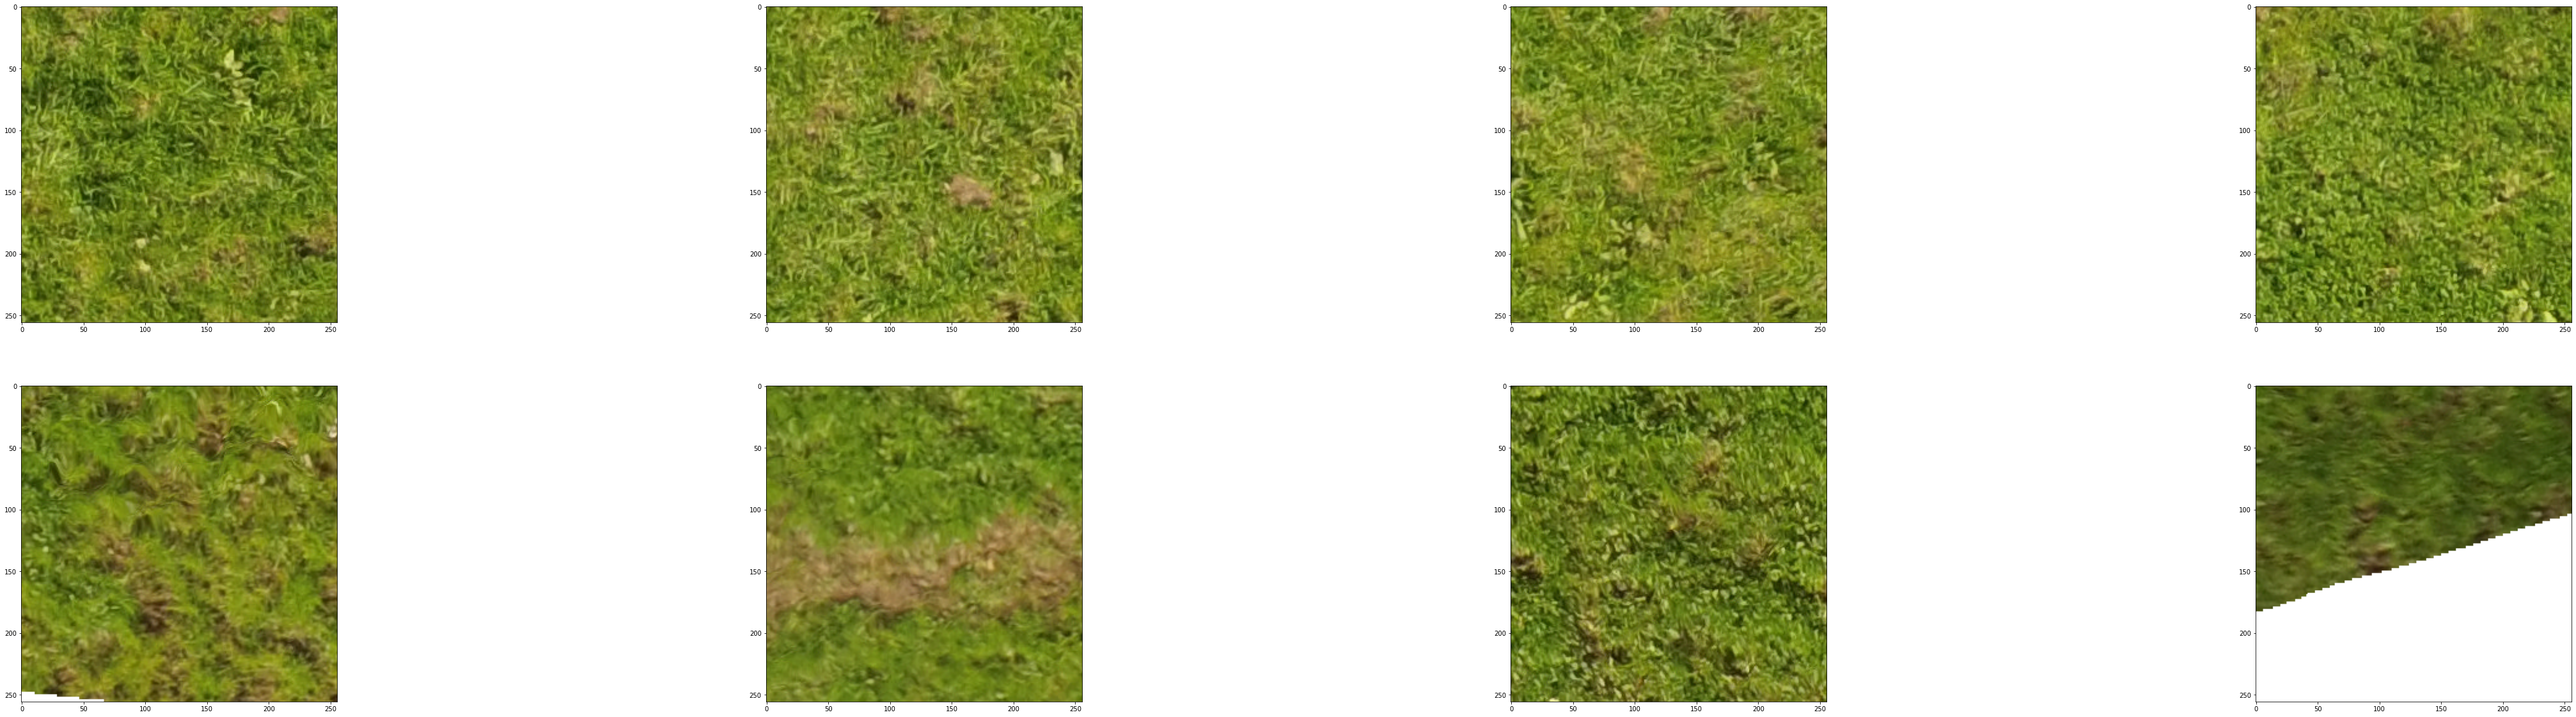

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datasets import BalancedRumexDataset

elevation = '15m'
first_mosaic = 0
last_mosaic = 4

base_filenames = {
    '10m': [
        'WENR_ortho_Rumex_10m_1_nw',
        'WENR_ortho_Rumex_10m_2_sw',
        'WENR_ortho_Rumex_10m_3_ne',
        'WENR_ortho_Rumex_10m_4_se'
    ],
    '15m': [
        'WENR_ortho_Rumex_15m_2_sw',
        'WENR_ortho_Rumex_15m_4_se']
}

training_set = BalancedRumexDataset(
    '/home/mariano/data/Wetlands/Rumex/', base_filenames[elevation][first_mosaic:last_mosaic],
    256, norm=False
)


plt.figure(figsize=(80, 20))
plt.subplot(2, 4, 1)
im_plant, _ = training_set[0]
plt.imshow(np.moveaxis(im_plant, 0, -1).astype(np.uint8))
plt.subplot(2, 4, 2)
im_plant, _ = training_set[1]
plt.imshow(np.moveaxis(im_plant, 0, -1).astype(np.uint8))
plt.subplot(2, 4, 3)
im_plant, _ = training_set[2]
plt.imshow(np.moveaxis(im_plant, 0, -1).astype(np.uint8))
plt.subplot(2, 4, 4)
im_plant, _ = training_set[3]
plt.imshow(np.moveaxis(im_plant, 0, -1).astype(np.uint8))
plt.subplot(2, 4, 5)
im_back, _ = training_set[len(training_set) // 2]
plt.imshow(np.moveaxis(im_back, 0, -1).astype(np.uint8))
plt.subplot(2, 4, 6)
im_back, _ = training_set[len(training_set) // 2]
plt.imshow(np.moveaxis(im_back, 0, -1).astype(np.uint8))
plt.subplot(2, 4, 7)
im_back, _ = training_set[len(training_set) // 2]
plt.imshow(np.moveaxis(im_back, 0, -1).astype(np.uint8))
plt.subplot(2, 4, 8)
im_back, _ = training_set[len(training_set) // 2]
plt.imshow(np.moveaxis(im_back, 0, -1).astype(np.uint8))

In [4]:
master_seed = 42

patch_size = 256
elevation = '10m'

path = '/home/mariano/data/Wetlands/Rumex/'
base_filenames = {
    '10m': [
        'WENR_ortho_Rumex_10m_1_nw',
        'WENR_ortho_Rumex_10m_2_sw',
        'WENR_ortho_Rumex_10m_3_ne',
        'WENR_ortho_Rumex_10m_4_se'
    ],
    '15m': [
        'WENR_ortho_Rumex_15m_2_sw',
        'WENR_ortho_Rumex_15m_4_se']
}

# XML loading.
base_filename = base_filenames[elevation][-1]
quadrant = base_filename.split("_")[-1]
imfile = base_filename + '.png'
xmlfile = base_filename + '.xml'
root = et.parse(os.path.join(path, xmlfile)).getroot()
xmlstr = et.tostring(root, encoding='utf-8', method='xml')
xmldict = dict(xmltodict.parse(xmlstr))

# Actual image size.
im_size = xmldict['annotation']['size']
im_height = int(im_size['height'])
im_width = int(im_size['width'])

# XML parsing to create the final mask based on bounding boxes.
mask = np.zeros((im_height, im_width), dtype=np.uint8)
objects = xmldict['annotation']['object']
nobjects = len(objects)
for i in range(nobjects):
    obj_i = objects[i]
    if obj_i['name'] == 'rumex':
        temp = obj_i['bndbox']
        mask[int(temp['ymin']):int(temp['ymax']), int(temp['xmin']):int(temp['xmax'])] = 255
mask_path = os.path.join(
    path, 'Saliency', 'rumex_mask_{:}-{:}.png'.format(elevation, quadrant)
)

# The experiments are run next. We capture some warnings related to
# image loading to clean the debugging console.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    skio.imsave(mask_path, mask)

    # ResNet18 experiment.
    run_experiments(
        master_seed, 'resnet18-{:}'.format(elevation),
        partial(ResNet18, lr=1e-4, pretrained=True),
        base_filenames[elevation][:-1], base_filenames[elevation][-1:],
        os.path.join(path, 'Weights'), os.path.join(path, 'Saliency'),
        epochs=100, patience=100, patch_size=patch_size, verbose=2
    )
    
    # ConvNext-tiny experiment.
    run_experiments(
        master_seed, 'convnext_t-{:}'.format(elevation),
        partial(ConvNeXtTiny, lr=1e-4, pretrained=True),
        base_filenames[elevation][:-1], base_filenames[elevation][-1:],
        os.path.join(path, 'Weights'), os.path.join(path, 'Saliency'),
        epochs=100, patience=100, patch_size=patch_size, verbose=2
    )
    
    # ViT experiment.
    # That experiment requires a large amount of GPU RAM.
    run_experiments(
        master_seed, 'vit_b_16-{:}'.format(elevation),
        partial(ViT_B_16, image_size=patch_size, patch_size=patch_size // 16, lr=1e-4, pretrained=True),
        base_filenames[elevation][:-1], base_filenames[elevation][-1:],
        os.path.join(path, 'Weights'), os.path.join(path, 'Saliency'),
        epochs=100, patience=100, patch_size=patch_size, verbose=2
    )

[11/09/2023 - 13:42:49] Creating testing dataset for rumex classification
[11/09/2023 - 13:42:49] Starting experiment (seed 15795) [01/30] for rumex classification
[11/09/2023 - 13:42:57] Accuracy  (seed 15795) [01/30] 0.924
[11/09/2023 - 13:42:57] Class accuracies  (seed 15795) [01/30] Class 0: 0.926, Class 1: 0.912
[11/09/2023 - 13:42:57] Starting experiment (seed 00860) [02/30] for rumex classification
[11/09/2023 - 13:43:01] Accuracy  (seed 00860) [02/30] 0.947
[11/09/2023 - 13:43:01] Class accuracies  (seed 00860) [02/30] Class 0: 0.943, Class 1: 0.971
[11/09/2023 - 13:43:01] Starting experiment (seed 76820) [03/30] for rumex classification
[11/09/2023 - 13:43:05] Accuracy  (seed 76820) [03/30] 0.951
[11/09/2023 - 13:43:05] Class accuracies  (seed 76820) [03/30] Class 0: 0.948, Class 1: 0.971
[11/09/2023 - 13:43:05] Starting experiment (seed 54886) [04/30] for rumex classification
[11/09/2023 - 13:43:08] Accuracy  (seed 54886) [04/30] 0.939
[11/09/2023 - 13:43:08] Class accuracies

           Epoch 010 |  0.5436 |  0.6041 |   0.6162 |   0.3629 |   0.2333 |   0.4096 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
           Epoch 011 |  0.5451 |  0.6156 |   0.5572 |   0.2776 |   0.3733 |   0.3045 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                     

           Epoch 023 |  0.3845 |  0.2519 |   0.4249 |   0.1671 |   0.0667 |   0.1963 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 024 |  0.3698 |  0.2544 |   0.4276 |   0.1705 |   0.0667 |   0.1988 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                              

           Epoch 036 |  0.2753 |  0.1436 |   0.2791 |   0.0786 |   0.0667 |   0.0880 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 037 |  0.2575 |  0.1643 |   0.2948 |   0.0952 |   0.0667 |   0.1087 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                       

           Epoch 049 |  0.2172 |  0.1208 |   0.2232 |   0.0619 |   0.0667 |   0.0652 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 050 |  0.2049 |  0.1285 |   0.2298 |   0.0686 |   0.0667 |   0.0729 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                              

           Epoch 062 |  0.1575 |  0.1249 |   0.2040 |   0.0652 |   0.0667 |   0.0694 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
           Epoch 063 |  0.1520 |  0.1249 |   0.2147 |   0.0652 |   0.0667 |   0.0694 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                          

           Epoch 075 |  0.1049 |  0.1138 |   0.1930 |   0.0552 |   0.0667 |   0.0583 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
           Epoch 076 |  0.1195 |  0.1138 |   0.2022 |   0.0552 |   0.0667 |   0.0583 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                          

           Epoch 088 |  0.1052 |  0.1103 |   0.1743 |   0.0519 |   0.0667 |   0.0548 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
           Epoch 089 |  0.0901 |  0.1103 |   0.1776 |   0.0519 |   0.0667 |   0.0548 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                     

           Epoch 000 |  0.6552 |  0.7296 |   0.6225 |   0.2824 |   0.5894 |   0.2384 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 001 |  0.6357 |  0.6441 |   0.6098 |   0.2543 |   0.4941 |   0.2324 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                

           Epoch 013 |  0.4359 |  0.2987 |   0.4426 |   0.1305 |   0.1867 |   0.1431 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 014 |  0.4300 |  0.3542 |   0.4566 |   0.1790 |   0.1867 |   0.1987 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                       

           Epoch 026 |  0.3010 |  0.1871 |   0.3280 |   0.1190 |   0.0667 |   0.1315 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
           Epoch 027 |  0.2874 |  0.1752 |   0.3217 |   0.1071 |   0.0667 |   0.1196 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                          

           Epoch 039 |  0.2371 |  0.1421 |   0.2544 |   0.0786 |   0.0667 |   0.0865 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
           Epoch 040 |  0.2292 |  0.1421 |   0.2564 |   0.0786 |   0.0667 |   0.0865 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                   

           Epoch 052 |  0.1941 |  0.1300 |   0.2263 |   0.0686 |   0.0667 |   0.0744 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
           Epoch 053 |  0.1797 |  0.1300 |   0.2316 |   0.0686 |   0.0667 |   0.0744 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                 

           Epoch 065 |  0.1502 |  0.1328 |   0.2063 |   0.0652 |   0.0784 |   0.0674 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
           Epoch 066 |  0.1347 |  0.1328 |   0.2044 |   0.0652 |   0.0784 |   0.0674 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                 

           Epoch 078 |  0.0993 |  0.1265 |   0.2160 |   0.0652 |   0.0667 |   0.0710 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
           Epoch 079 |  0.1307 |  0.1286 |   0.2031 |   0.0619 |   0.0784 |   0.0632 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                          

           Epoch 091 |  0.0688 |  0.1286 |   0.1987 |   0.0619 |   0.0784 |   0.0632 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
           Epoch 092 |  0.0909 |  0.1326 |   0.1812 |   0.0552 |   0.0984 |   0.0506 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                          

           Epoch 002 |  0.6438 |  0.6977 |   0.6409 |   0.3329 |   0.4573 |   0.3167 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
           Epoch 003 |  0.6326 |  0.6558 |   0.6168 |   0.2995 |   0.4455 |   0.2846 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                     

           Epoch 015 |  0.4560 |  0.4062 |   0.4230 |   0.1386 |   0.3267 |   0.1339 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
           Epoch 016 |  0.4444 |  0.3728 |   0.4206 |   0.1319 |   0.2867 |   0.1339 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                          

           Epoch 028 |  0.3040 |  0.1733 |   0.3014 |   0.0952 |   0.0867 |   0.1011 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
           Epoch 029 |  0.3179 |  0.1768 |   0.3133 |   0.0986 |   0.0867 |   0.1046 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                          

           Epoch 041 |  0.2380 |  0.1523 |   0.2266 |   0.0719 |   0.0984 |   0.0703 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
           Epoch 042 |  0.2559 |  0.1472 |   0.2212 |   0.0686 |   0.0984 |   0.0652 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                          

           Epoch 054 |  0.2019 |  0.1425 |   0.2158 |   0.0686 |   0.0867 |   0.0703 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
           Epoch 055 |  0.1952 |  0.1438 |   0.1945 |   0.0652 |   0.0984 |   0.0617 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                 

           Epoch 067 |  0.1564 |  0.1291 |   0.1636 |   0.0519 |   0.0984 |   0.0471 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 068 |  0.1297 |  0.1374 |   0.1963 |   0.0652 |   0.0867 |   0.0652 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                              

           Epoch 080 |  0.1029 |  0.1403 |   0.1771 |   0.0619 |   0.0984 |   0.0583 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
           Epoch 081 |  0.1077 |  0.1410 |   0.2049 |   0.0686 |   0.0867 |   0.0688 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                 

           Epoch 093 |  0.0717 |  0.1327 |   0.1776 |   0.0552 |   0.0984 |   0.0506 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
           Epoch 094 |  0.0646 |  0.1327 |   0.1664 |   0.0552 |   0.0984 |   0.0506 | 0.000 | 18s                                                                                                                                                                                                                                                                                                                 

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.76 GiB total capacity; 9.11 GiB already allocated; 4.25 MiB free; 9.78 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF